# Analysis of interacting case for optimal variational parameters

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
import pandas as pd
import numpy as np

from vmc.interface import *
from vmc import run_all

from IPython.core.display import display

In [2]:
#sns.set(color_codes=True)

In [3]:
mass = 1.0
omega = 1.0

radius = 0.0043
beta = _lambda = 2.82843

dw_radius = 2.0

num_particles = 10
num_dimensions = 3

step_length = 0.1

num_samples = int(2**20)
num_thermalization_steps = int(0.1*num_samples)

r_min = -4
r_max = 4
num_bins = 100


parameter_names = ["alpha"]
alpha = np.array([0.4974]).reshape(1, 1)
alpha_s = np.array([0.5]).reshape(1, 1)

kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [4]:
sampler_i = PySampler(
    PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, radius,
        spread=np.sqrt(step_length)
    ), PyEllipticalHarmonicOscillator(_lambda),
    PyImportanceMetropolis()
)

sampler_n = PySampler(
    PyInteractingEllipticalGaussian(
        num_particles, num_dimensions, mass, omega, beta, 0,
        spread=np.sqrt(step_length)
    ), PyEllipticalHarmonicOscillator(_lambda),
    PyImportanceMetropolis()
)

sampler_s = PySampler(
    PySimpleGaussian(
        num_particles, num_dimensions, mass, omega, spread=np.sqrt(step_length)
    ), PyHarmonicOscillator(),
    PyImportanceMetropolis()
)

sampler_dw = PySampler(
    PySimpleGaussian(
        num_particles, num_dimensions, mass, omega, spread=np.sqrt(step_length)
    ), PyDoubleWell(dw_radius),
    PyImportanceMetropolis()
)

sampler_i.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_n.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_s.initialize_one_body_densities(r_min, r_max, num_bins)
sampler_dw.initialize_one_body_densities(r_min, r_max, num_bins)

In [5]:
df_i = run_all(sampler_i, alpha, parameter_names, 0, **kwargs)
df_i["energy_per_particle"] = df_i["energy"]/num_particles

100%|██████████| 1/1 [00:11<00:00, 11.77s/it]


In [6]:
display(df_i)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.4974,24.398523,2.671369e-09,0.000052,0.961981,11.692209,1.163888e-07,0.000341,2.439852


In [7]:
df_n = run_all(sampler_n, alpha, parameter_names, 0, **kwargs)
df_n["energy_per_particle"] = df_n["energy"]/num_particles

100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


In [8]:
display(df_n)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.4974,24.142364,1.296081e-09,0.000036,0.962399,10.627003,6.012999e-08,0.000245,2.414236


In [9]:
df_s = run_all(sampler_s, alpha_s, parameter_names, 0, **kwargs)
df_s["energy_per_particle"] = df_s["energy"]/num_particles

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


In [10]:
display(df_s)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.5,15.0,0.0,0.0,0.985721,1.230965,0.0,0.0,1.5


In [11]:
df_dw = run_all(sampler_dw, alpha_s, parameter_names, 0, **kwargs)
df_dw["energy_per_particle"] = df_dw["energy"]/num_particles

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


In [12]:
display(df_dw)

,alpha,energy,variance,std,acceptance,sampling_time,block_var,block_std,energy_per_particle
0,0.5,14.374093,0.000002,0.00132,0.985681,1.313093,0.000153,0.01237,1.437409


In [13]:
bins_i = sampler_i.get_one_body_densities()
bins_n = sampler_n.get_one_body_densities()
bins_s = sampler_s.get_one_body_densities()
bins_dw = sampler_dw.get_one_body_densities()
radii = np.linspace(r_min, r_max, num_bins)

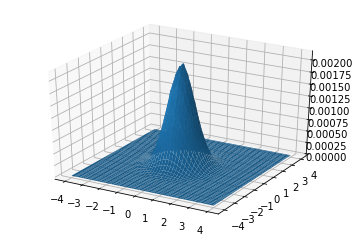

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
xv, yv = np.meshgrid(radii, radii)
ax.plot_surface(xv, yv, np.outer(bins_dw[:, ::3], bins_dw[:, ::3]))
plt.show()

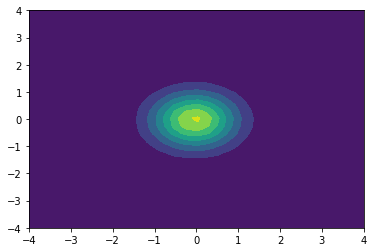

In [15]:
plt.contourf(radii, radii, np.outer(bins_dw[:, ::3], bins_dw[:, ::3]))
plt.show()

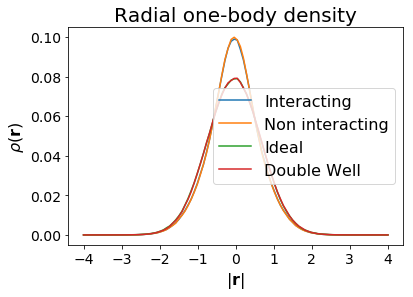

In [16]:
plt.plot(radii, np.linalg.norm(bins_i, axis=1), label=r"Interacting")
plt.plot(radii, np.linalg.norm(bins_n, axis=1), label=r"Non interacting")
plt.plot(radii, np.linalg.norm(bins_s, axis=1), label=r"Ideal")
plt.plot(radii, np.linalg.norm(bins_dw, axis=1), label=r"Double Well")

plt.title(r"Radial one-body density", fontsize=20)
plt.xlabel(r"$|\mathbf{r}|$", fontsize=16)
plt.ylabel(r"$\rho(\mathbf{r})$", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="best", fontsize=16)
plt.savefig("../data/figures/problem_g.pdf")

plt.show()

In [17]:
abs_radii = np.linspace(0, r_max, num_bins//2)
abs_bins_i = np.linalg.norm(bins_i, axis=1)
abs_bins_i = (abs_bins_i[:num_bins//2])[::-1] + abs_bins_i[num_bins//2:]

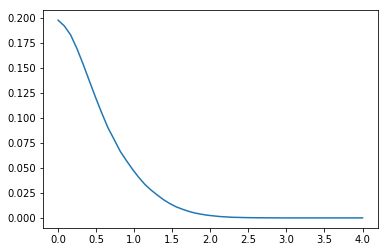

In [18]:
plt.plot(abs_radii, abs_bins_i, label=r"Interacting")
plt.show()